In [1]:
import pickle
import matplotlib.pyplot as plt

# import mod_kernik as kernik

#############################################
from scipy.integrate import ode, solve_ivp
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bisect

sys.path.append('../')
from Protocols.pacing_protocol import PacingProtocol
from Protocols.leakstaircase import LeakStaircase


import scipy_simulator

sys.path.append('../Lib')

sys.path.append('../models')
from Models.br1977 import BR1977

import mod_trace as trace
#############################################

def get_high_fitness(ga_result):
    best_individual = ga_result.generations[0][0]

    for i, gen in enumerate(ga_result.generations):
        best_in_gen = ga_result.get_high_fitness_individual(i)
        if best_in_gen.fitness > best_individual.fitness:
            best_individual = best_in_gen

    return best_individual

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def get_model_response_JK( model, protocol, prestep=None):    
    
    simulator = scipy_simulator.Simulator(model)     
    
    if prestep == None:
        print("There is no pre-step simulation.")
    elif prestep == 'pre':
        print("There is no pre-step simulation.")
    else:
        prestep_protocol = protocols.VoltageClampProtocol( [protocols.VoltageClampStep(voltage=-84.622, duration=prestep)] )
        simulator.model.protocol = prestep_protocol
        simulator.simulate( [0, prestep_protocol.get_voltage_change_endpoints()[-1]] )                 
        simulator.model.y0 = simulator.solver.y[:,-1]             
        
    simulator.model.protocol = protocol
    simulator.simulate( [0, protocol.get_voltage_change_endpoints()[-1]] ) 
    
    command_voltages = [protocol.get_voltage_at_time(t) for t in simulator.model.times]

    # print("dd11",len(model.current_response_info.currents))
    
    simulator.model.current_response_info = trace.CurrentResponseInfo()
    if len(simulator.solver.y) < 200:
        list(map(simulator.model.differential_eq, simulator.solver.t, simulator.solver.y.transpose()))
    else:
        list(map(simulator.model.differential_eq, simulator.solver.t, simulator.solver.y))               
    
    # print("dd22",len(model.current_response_info.currents))
    
    tr = trace.Trace(protocol,
                     cell_params=None,
                     t=simulator.model.times,
                     y=simulator.model.V,
                     command_voltages=command_voltages,
                     current_response_info=model.current_response_info,
                     default_unit=None)
    
    return tr

In [3]:
def plot_current_conributions():
    trial_conditions = "trial_steps_ramps_BR1977_2_2_4_-120_60"
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']

    for i, current in enumerate(currents):
        ga_result = pickle.load(open(f'ga_results/{trial_conditions}/ga_results_{current}_artefact_False', 'rb'))
        best_individual = get_high_fitness(ga_result)
        protocol = best_individual.protocol
        
        model = BR1977(protocol)        
        tr = get_model_response_JK(model, protocol)
        # k = kernik.KernikModel(is_exp_artefact=True)        
        # tr = k.generate_response(proto, is_no_ion_selective=False)

        tr.plot_currents_contribution(current, is_shown=True, title=current,
                saved_to=f'./ga_results/{trial_conditions}/{current}.svg')


There is no pre-step simulation.


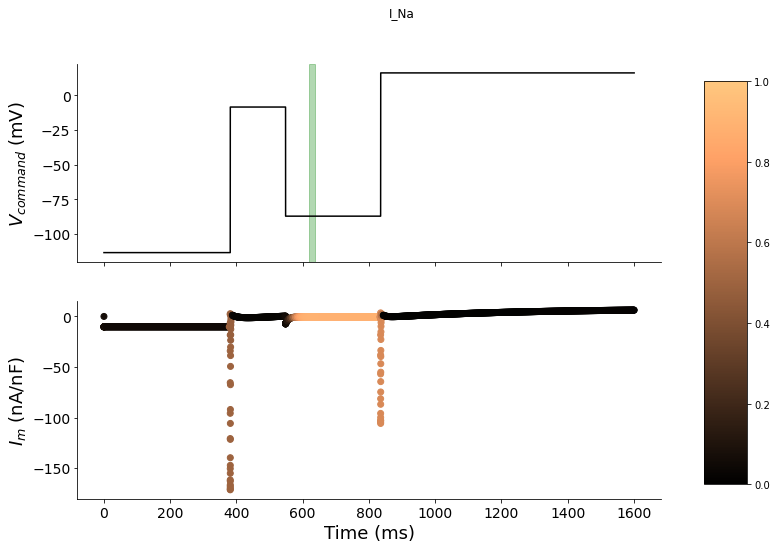

There is no pre-step simulation.


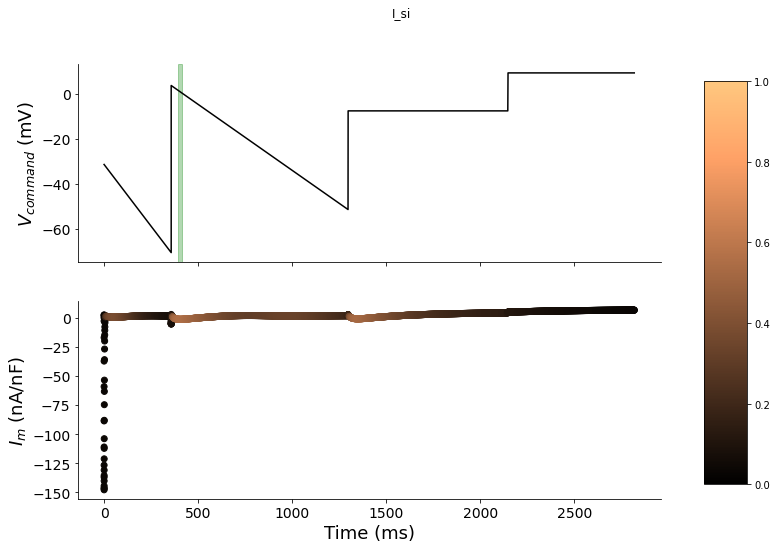

There is no pre-step simulation.


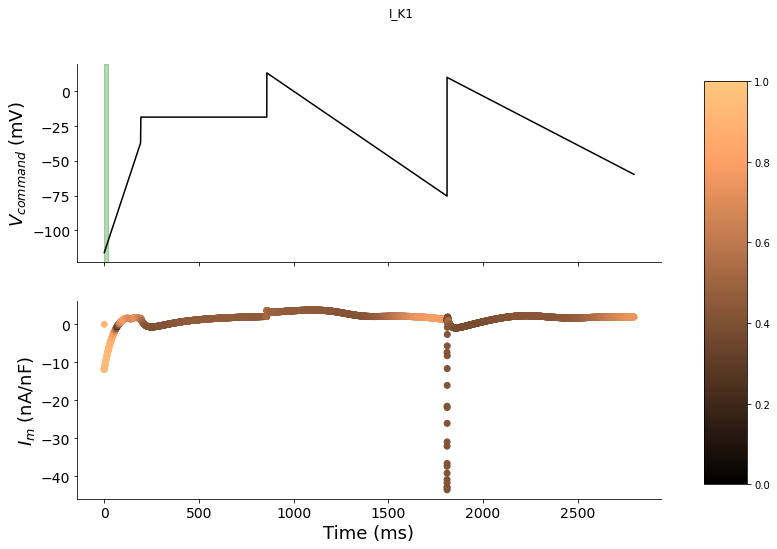

There is no pre-step simulation.


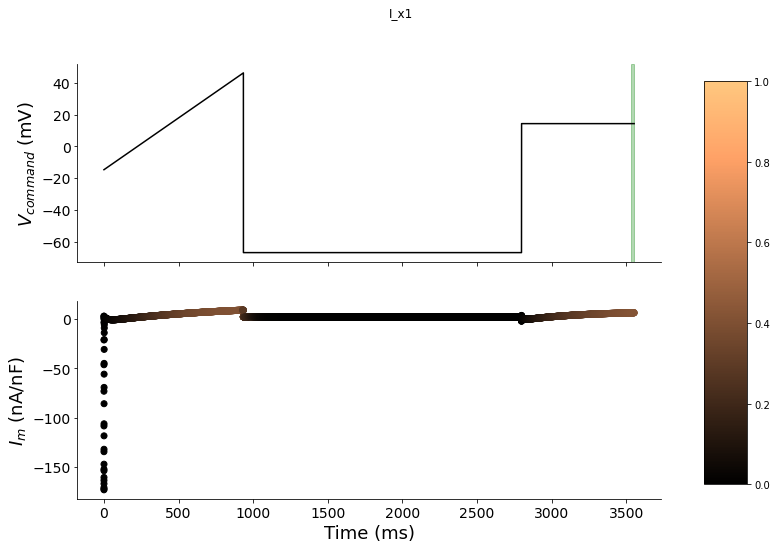

In [4]:
def main():
    plot_current_conributions()

if __name__ == '__main__':
    main()